# Processing of the raw data captured by some TS4231 chip, using LH2
#### Author : Mathieu Schnegg
#### Date : 07.05.2020
#### Goal : Compute the azimuth and elevation angles from the data received by a TS4231 chip
Process :

1. Find Bi-Phase Mark Code (FM1) sequences with a lenght of 34 bits
2. Decode the sequences -> resulting in some 17 bits sequences
3. Find the LFSR that has been used on the 17 bits sequences
4. Run back the LFSR to find the offset information
5. Compute the azimuth and elevation angles

# Initialization

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lfsr import LFSR
import itertools
from math import sin,tan,atan;

#### Display all the files in the directory

In [130]:
!ls ~/library

digital.csv  one_sweep.csv  Raw_data_processing.ipynb
lfsr.py      __pycache__    README.md


# Import capture file

In [131]:
data = pd.read_csv("~/library/one_sweep.csv")

#### Print all the index of the file

In [132]:
print(data.columns);

Index(['Time[s]', ' Channel 0', ' Channel 1', ' Channel 2', ' Channel 3',
       ' Channel 4', ' Channel 5'],
      dtype='object')


#### Extract signals

In [133]:
t          = data['Time[s]']
data_0     = data[' Channel 0']
envelope_0 = data[' Channel 1']
data_1     = data[' Channel 2']
envelope_1 = data[' Channel 3']
data_2     = data[' Channel 4']
envelope_2 = data[' Channel 5']

#### Display signals

<Figure size 432x288 with 0 Axes>

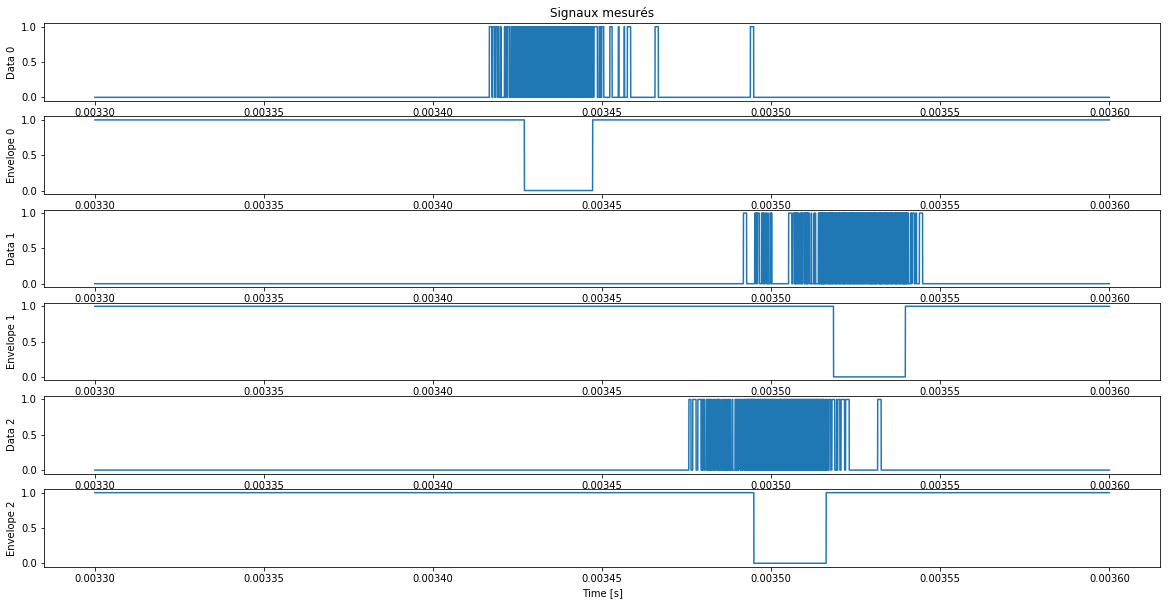

In [134]:
plt.figure();
plt.figure(figsize=(20,10))

plt.subplot(611);
plt.title('Signaux mesurés');
plt.plot(t,data_0);
plt.ylabel('Data 0');

plt.subplot(612);
plt.plot(t,envelope_0);
plt.ylabel('Envelope 0');

plt.subplot(613);
plt.plot(t,data_1);
plt.ylabel('Data 1');

plt.subplot(614);
plt.plot(t,envelope_1);
plt.ylabel('Envelope 1');

plt.subplot(615);
plt.plot(t,data_2);
plt.ylabel('Data 2');

plt.subplot(616);
plt.plot(t,envelope_2);
plt.ylabel('Envelope 2');

plt.xlabel('Time [s]');
plt.show();

# Signals parameters

In [142]:
f     = 12*10**6;    # Signals bitrate
T     = 1/f;         # Signals period
f_ech = 100*10**6;   # Sampling frequency
T_ech = 1/f_ech;     # Sampling period
R     = f_ech/f;     # Ratio 
print('Ratio =',R);

Ratio = 8.333333333333334


# Search for 34 bits sequence of Bi-Phase Mark Code (FM1)

#### Parameters

In [143]:
PERIOD_TOLERANCE        = 25;  # Period tolerance in %
VAL1                    = 1;
VAL2                    = 2;
WORD_LENGTH             = 34;
MAX_CONSECUTIVE_SYMBOLS = 2;
L                       = len(data_0);
sequences_FM1 = np.zeros((10,34), dtype=int);
count_0       = 0;
count_1       = 0;
nb_symbols    = 0;
nb_sequences  = 0;

#### Functions used

In [144]:
def adjust(seq):
    for i in range(0,33):
        seq[i]=seq[i+1];
    return seq;

def sum_17bits(seq):
    k = 0;
    result = 0;
    for j in range(0,17):
        if(seq[k]==seq[k+1]):
            return -1;
        else:
            result=result+1;
        k = k+2;
    return result;

def clear_seq(seq):
    for i in range(0,34):
        seq[i]=0;
    return seq;

def check_count(count,sequences_FM1,nb_sequences,nb_symbols,bit):
    if(count):
        count = count/R;
        if((count>VAL1-VAL1*PERIOD_TOLERANCE/100) and (count<VAL1+VAL1*PERIOD_TOLERANCE/100)):
            sequences_FM1[nb_sequences,nb_symbols]=bit;
            nb_symbols = nb_symbols + 1;
            if (nb_symbols == WORD_LENGTH):
                # Check if adjust is needed
                if(sum_17bits(sequences_FM1[nb_sequences,:])==17):
                    sequences_FM1[nb_sequences,:]=adjust(sequences_FM1[nb_sequences,:]);
                    nb_symbols = nb_symbols - 1;
                else:
                    nb_sequences = nb_sequences + 1;
                    nb_symbols = 0;

        elif((count>VAL2-VAL2*PERIOD_TOLERANCE/100) and (count<VAL2+VAL2*PERIOD_TOLERANCE/100)):
            for j in range(0,2):
                sequences_FM1[nb_sequences,nb_symbols]=bit;
                nb_symbols = nb_symbols + 1;
                if (nb_symbols == WORD_LENGTH):
                    # Check if adjust is needed
                    if(sum_17bits(sequences_FM1[nb_sequences,:])==17):
                        sequences_FM1[nb_sequences,:]=adjust(sequences_FM1[nb_sequences,:]);
                        nb_symbols = nb_symbols - 1;
                    else:
                        nb_sequences = nb_sequences + 1;
                        nb_symbols = 0;

        else:
            nb_symbols = 0;
            sequences_FM1[nb_sequences,:]=clear_seq(sequences_FM1[nb_sequences,:]);

        count = 0;
        
    return count,sequences_FM1,nb_sequences,nb_symbols;

#### Run algorithm

In [145]:
for i in range(0,L):
    if (data_0[i] == 0):
        [count_1,sequences_FM1,nb_sequences,nb_symbols]=check_count(count_1,sequences_FM1,nb_sequences,nb_symbols,1);
        count_0+=1;   
    else:
        [count_0,sequences_FM1,nb_sequences,nb_symbols]=check_count(count_0,sequences_FM1,nb_sequences,nb_symbols,0);
        count_1+=1;  

#### Display found sequences 

In [146]:
print(sequences_FM1)

[[1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1]
 [0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0]
 [1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1]
 [0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


# Decode Bi-Phase Mark Code (FM1)
34 bits -> 17 bits

In [147]:
stream_17bits = np.zeros ((10,17), dtype=int);
k = 0;

for i in range(0,10):
    for j in range(0,17):
        if(sequences_FM1[i,k]==sequences_FM1[i,k+1]):
            stream_17bits[i,j]=0;
        else:
            stream_17bits[i,j]=1;
        k = k+2;
    k=0;

#### Display decoded sequences 

In [148]:
print(stream_17bits)

[[0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0]
 [1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1]
 [0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1]
 [0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


#### Convert from binary to decimal

In [149]:
words = np.zeros ((10,1), dtype=int);

for i in range(0,10):
    for j in range(0,17):
          words[i]=words[i]+stream_17bits[i,j]*2**(16-j);         

#### Display decimal values

In [150]:
print(words);         

[[  3016]
 [121691]
 [ 43577]
 [ 45637]
 [     0]
 [     0]
 [     0]
 [     0]
 [     0]
 [     0]]


# Find the LFSR that has been used
Goal: using the first 17bits word of two sensor for :
        1. extract the LFSR polynomials used by finding the smaller delta (since the two sensors are close to each other)
        2. find the offset of each word

#### Constants used by LH2
Polynomials (16 pairs of 2) and periods (16)

In [118]:
# First one is x^17 + x^13 + x^12 + x^10 + x^7 + x^4 + x^2 + x^1 + 1
polys = [0x0001D258, 0x00017E04,
         0x0001FF6B, 0x00013F67,
         0x0001B9EE, 0x000198D1,
         0x000178C7, 0x00018A55,
         0x00015777, 0x0001D911,
         0x00015769, 0x0001991F,
         0x00012BD0, 0x0001CF73,
         0x0001365D, 0x000197F5,
         0x000194A0, 0x0001B279,
         0x00013A34, 0x0001AE41,
         0x000180D4, 0x00017891,
         0x00012E64, 0x00017C72,
         0x00019C6D, 0x00013F32,
         0x0001AE14, 0x00014E76,
         0x00013C97, 0x000130CB,
         0x00013750, 0x0001CB8D]

# Expressed using a 48 MHz clock
periods = [959000, 957000,
           953000, 949000,
           947000, 943000,
           941000, 939000,
           937000, 929000,
           919000, 911000,
           907000, 901000,
           893000, 887000]

#### Running the LFSR and sort the delta from smallest to largest

In [151]:
def nth(iterable, nth):
    return next(itertools.islice(iterable, nth, nth+1))

def search(poly, cipher):
    i = 0
    lfsr = LFSR(poly)
    while (next(lfsr) != cipher): i += 1
    return i

# cipher captured to test
cipher1 = 3016;
cipher2 = 68648;

candidates = np.zeros((32,3),dtype=int);

for k in range(0,32):
    candidates[k,0] = k;
    candidates[k,2] = search(polys[k], cipher1);
    candidates[k,1] = abs(candidates[k][2] - search(polys[k], cipher2));
    
candidates = sorted(candidates,key=lambda x: x[1]); 

# Can be done in one line :
#candidates = sorted([(k,abs(search(poly, cipher1) - search(poly, cipher2)))for k, poly in enumerate(polys)],key=lambda x: x[1])

#### Display the result

In [152]:
lfsr_found = candidates[0][0];
delta      = candidates[0][1];
offset     = candidates[0][2];
print('Delta :',delta);
print('LFSR  :',lfsr_found);

offset1 = offset;
offset2 = offset+delta;
print('Offset1 :',offset1);
print('Offset2 :',offset2);

Delta : 541
LFSR  : 0
Offset1 : 41803
Offset2 : 42344


#### Check, run back the LFSR

In [153]:
u = nth(LFSR(polys[lfsr_found]), 41803);
v = nth(LFSR(polys[lfsr_found]), 42344);

if(u==cipher1):
    print(u,': Offset1 ok');
else:
    print(u,': Offset1 not ok');
    
if(v==cipher2):
    print(v,': Offset2 ok');
else:
    print(v,': Offset2 not ok');

3016 : Offset1 ok
68648 : Offset2 ok


#### Base station channel

In [154]:
ch = lfsr_found / 2 + 1;
print('Channel : ',ch);

Channel :  1.0


# Compute the azimuth and elevation angles
9 capture (Saleae logic analyser) have been made at 2 meters of a LH2, in 9 different positions. 
Offsets have been extracted and put in the two arrays below (firstBeam and secondBeam)

#### Array with the 9 offsets (two sweep each) 

In [155]:
firstBeam = [61507,42498,24321,
             56283,37145,21413,
             51496,33788,16477];

secondBeam = [93857,72208,57013,
              95241,76838,61034,
              100825,83167,65825];

#### Array to stock the azimuth and elevation angles

In [156]:
azimuth = np.zeros((9,1),dtype=float);
elevation = np.zeros((9,1),dtype=float);

#### Compute the azimuth and elevation angles

In [157]:
for i in range(0,9):
    firstBeam[i]  = ((firstBeam[i]  * 8.0) / periods[0]) * 2 * np.pi;
    secondBeam[i] = ((secondBeam[i] * 8.0) / periods[0]) * 2 * np.pi;

    azimuth[i] = ((firstBeam[i] + secondBeam[i]) / 2) - np.pi;
    p = 60/180*np.pi;
    beta = (secondBeam[i] - firstBeam[i]) - 120/180*np.pi;
    elevation[i] = atan(sin(beta/2)/tan(p/2));

# Display final results

In [160]:
print('Top left')
print('  azimuth   (deg) :',  azimuth[0]/np.pi*180);
print('  elevation (deg) :',elevation[0]/np.pi*180);
print('Top center')
print('  azimuth   (deg) :',  azimuth[1]/np.pi*180);
print('  elevation (deg) :',elevation[1]/np.pi*180);
print('Top right')
print('  azimuth   (deg) :',  azimuth[2]/np.pi*180);
print('  elevation (deg) :',elevation[2]/np.pi*180);
print('');
print('Middle left')
print('  azimuth   (deg) :',  azimuth[3]/np.pi*180);
print('  elevation (deg) :',elevation[3]/np.pi*180);
print('Middle center')
print('  azimuth   (deg) :',  azimuth[4]/np.pi*180);
print('  elevation (deg) :',elevation[4]/np.pi*180);
print('Middle right')
print('  azimuth   (deg) :',  azimuth[5]/np.pi*180);
print('  elevation (deg) :',elevation[5]/np.pi*180);
print('');
print('Bottom left')
print('  azimuth   (deg) :',  azimuth[6]/np.pi*180);
print('  elevation (deg) :',elevation[6]/np.pi*180);
print('Bottom center')
print('  azimuth   (deg) :',  azimuth[7]/np.pi*180);
print('  elevation (deg) :',elevation[7]/np.pi*180);
print('Bottom right')
print('  azimuth   (deg) :',  azimuth[8]/np.pi*180);
print('  elevation (deg) :',elevation[8]/np.pi*180);

Top left
  azimuth   (deg) : [53.28900938]
  elevation (deg) : [-18.93584359]
Top center
  azimuth   (deg) : [-7.76158498]
  elevation (deg) : [-24.68457035]
Top right
  azimuth   (deg) : [-57.87178311]
  elevation (deg) : [-18.15149498]

Middle left
  azimuth   (deg) : [47.52300313]
  elevation (deg) : [-2.59956906]
Middle center
  azimuth   (deg) : [-8.84721585]
  elevation (deg) : [-0.69003612]
Middle right
  azimuth   (deg) : [-56.20054223]
  elevation (deg) : [-0.87725161]

Bottom left
  azimuth   (deg) : [48.71974974]
  elevation (deg) : [22.83562885]
Bottom center
  azimuth   (deg) : [-4.38456726]
  elevation (deg) : [22.94266653]
Bottom right
  azimuth   (deg) : [-56.41826903]
  elevation (deg) : [22.87632721]


# End of file